rBergomi
==

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := S_0 \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi\ \exp \left\{ \eta \widetilde{W}_t^H - \frac{\eta^2}{2} t^{2H}\right\}, \quad \widetilde{W}_t^H := \sqrt{2H} \int_0^t (t - u)^{-\gamma}  \mathrm{d}W^1_u,$$

$\gamma = \frac{1}{2}- H$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $\widetilde{W}_t^H$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we show implied volatilities, $\hat{\sigma}^N_{BS}(k,t)$,  estimated using the following estimator,

$$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0),$$

as described in [McCrickerd and Pakkanen](https://arxiv.org/abs/1708.02563).

Change directory to folder with rBergomi scripts

In [1]:
import os
#os.chdir('/Users/maalejach/Desktop/rough_bergomi/rbergomi')

Import required libraries, classes and functions

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from rbergomi_cholesky import rBergomi_cholesky
from utils import bsinv, Implied_Vol_dicho
vec_bsinv = np.vectorize(bsinv)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.linear_model import LinearRegression
from math import ceil
init_notebook_mode(connected=True)
%matplotlib inline

we set all the parameters of the model :

In [3]:
H,eta,xi,rho = 0.07, 1.9, 0.15**2, -0.9

Create instance of the rBergomi class with $n$ steps per year, $N$ paths, maximum maturity $T$ and roughness index $a$

In [4]:
rB = rBergomi(n = 250, N = 30000, T = 1, H = H)

Fix the generator's seed for replicable results

In [5]:
#np.random.seed(0)

Generate required Brownian increments

In [6]:
dW1 = rB.dW1()
dW2 = rB.dW2()

In [19]:
dW1[:,5]

array([[-0.07510524, -1.68622643],
       [ 0.20754032,  1.55142579],
       [-0.0366128 ,  0.89540294],
       ...,
       [-0.07879444, -3.25752612],
       [-0.09964677, -1.80918316],
       [-0.01172428, -1.83093486]])

Construct the Volterra process, $$\widetilde{W}_t^H := \sqrt{2H} \int_0^t (t - u)^{-\gamma}  \mathrm{d}W^1_u$$

In [8]:
Y = rB.Y(dW1)

Correlate the orthogonal increments, using $\rho$, $$B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2$$

In [9]:
dB = rB.dB(dW1, dW2, rho = rho)

Construct the variance process, using $\xi$ and $\eta$, $$V_t := \xi\ \exp \left\{ \eta \widetilde{W}_t^H - \frac{\eta^2}{2} t^{2H}\right\}$$

In [10]:
V = rB.V(Y, xi = xi, eta = eta) 

Finally construct the price process, $$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\}$$

In [11]:
S0 = 100
S = rB.S(V, dB, S0=S0)

Now replicate implied volatiliies shared by [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004). Fix the log-strike range, $k$

In [11]:
k = np.arange(-0.5, 0.3, 0.01)

Compute call payoffs, prices, and implied volatilities, $$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0)$$

In [12]:
T = 1.0
ST = S[:,-1][:,np.newaxis]
K = S0*np.exp(k)[np.newaxis,:]
call_payoffs = np.maximum(ST - K,0)
call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
implied_vols = vec_bsinv(call_prices, S0, np.transpose(K), rB.T)

### plot call price

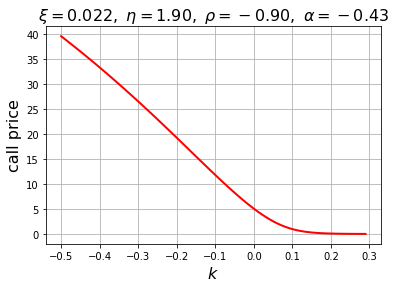

In [13]:
plot, axes = plt.subplots()
axes.plot(k,call_prices, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'call price', fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

### Plot implied volatilities 

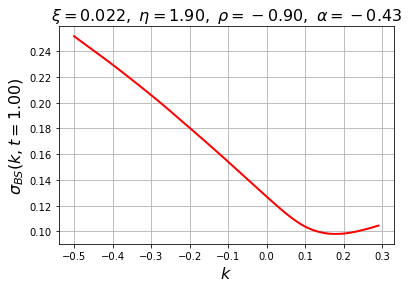

In [14]:
plot, axes = plt.subplots()
axes.plot(k,implied_vols, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

### compare paths for different H :

In [12]:
def compare_paths_H(S0=100,list_H=[0.499,0.07],T = 1.0, n=200, N=2000, H = 0.07, rho=-0.9, sigma0 = 0.15, eta = 1.9):
    fig, ax = plt.subplots(3,2, figsize=(15,10), sharex=True)
    for i,H in enumerate(list_H):
        ax[0,i].set_title("H = "+str(round(H,2)), fontsize=16)
        rB = rBergomi(n = n, N = N, T = T, H = H)
        dW1 = rB.dW1()
        dW2 = rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho = rho)
        V = rB.V(Y, xi = sigma0**2, eta = eta) 
        S = rB.S(V, dB, S0=S0)
        ax[0,i].plot(rB.t[0],Y[100,:])
        ax[0,i].plot(rB.t[0],Y[500,:])
        ax[0,i].plot(rB.t[0],Y[1000,:])
        ax[0,i].set_ylabel("$W^H_t$", fontsize=16)
        ax[1,i].plot(rB.t[0],V[100,:])
        ax[1,i].plot(rB.t[0],V[500,:])
        ax[1,i].plot(rB.t[0],V[1000,:])
        ax[1,i].set_ylabel("$V_t$", fontsize=16)
        ax[2,i].plot(rB.t[0],S[100,:])
        ax[2,i].plot(rB.t[0],S[500,:])
        ax[2,i].plot(rB.t[0],S[1000,:])
        ax[2,i].set_ylabel("$S_t$", fontsize=16)
        ax[2,i].set_xlabel("t",fontsize=15)

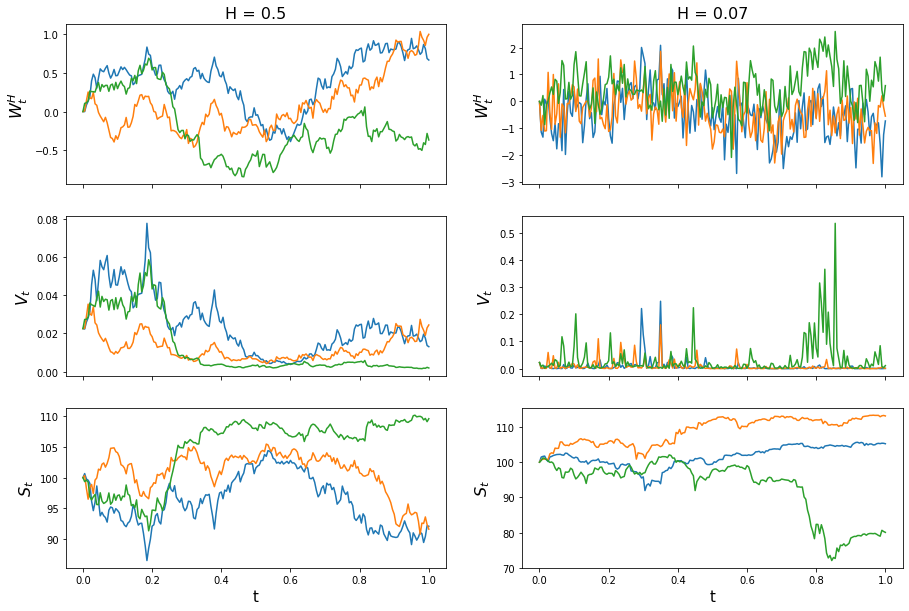

In [13]:
compare_paths_H()

# Fonctions pour generer les paths rough vol + implied volatility :

### With hybrid Scheme :

In [11]:
import os
import pandas as pd
import time

In [12]:
def generate_rBergomi_paths(S0, T = 1.0, n=100, N=30000, H = 0.07, rho=-0.9, sigma0 = 0.15, eta = 1.9):
    rB = rBergomi(n = n, N = N, T = T, H = H)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = sigma0**2, eta = eta) 
    S = rB.S(V, dB, S0=S0)
    return S

In [13]:
def find_imp_vols(S, K, T=1.0, r=0):
    ST = S[:,-1][:,np.newaxis]
    call_payoffs = np.maximum(ST - K,0)
    call_prices = np.exp(-r*T)*np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    implied_vols = vec_bsinv(call_prices, S[0][0], np.transpose(K), T)
    return implied_vols

In [14]:
S0=100
start_time = time.time()
S = generate_rBergomi_paths(S0=S0, N=100000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.412124872207642 seconds ---


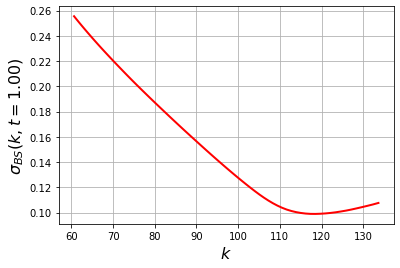

In [15]:
k = np.arange(-0.5, 0.3, 0.01) # moneyness
K = S0*np.exp(k)[np.newaxis,:] # Strikes
implied_vols1 = find_imp_vols(S, K)

plot, axes = plt.subplots()
axes.plot(K[0],implied_vols1, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
#title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ H=%.2f $'
#axes.set_title(title%(rB.xi, rB.eta, rB.rho, 0.5+rB.a), fontsize=16)
plt.grid(True)

### With Cholesky decomposition :

In [20]:
rb = rBergomi_cholesky(N=100000, H=0.07, eta=1.9, rho=-0.9, sigma0=0.15)

In [21]:
S0 = 100
start_time = time.time()
S2 = rb.simul_S(S0=S0)
print("--- %s seconds ---" % (time.time() - start_time))

i 99000/100000.--- 11.193017959594727 seconds ---


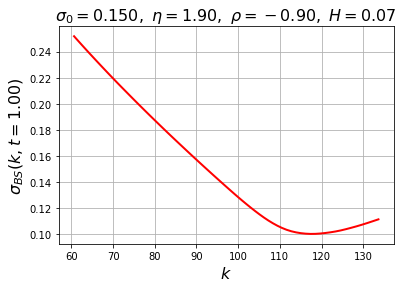

In [22]:
k = np.arange(-0.5, 0.3, 0.01) # moneyness
K = S0*np.exp(k)[np.newaxis,:] # Strikes
implied_vols2 = find_imp_vols(S2, K)

plot, axes = plt.subplots()
axes.plot(K[0],implied_vols2, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\sigma_0=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ H=%.2f $'
axes.set_title(title%(rb.sigma0, rb.eta, rb.rho, rb.H), fontsize=16)
plt.grid(True)

### comparison :

In [24]:
N_list = [100,1000,5000,10000,30000,50000,100000]
S0=100

In [26]:
time_simulation_hbss_scheme = []
for N in N_list:
    start_time = time.time()
    S = generate_rBergomi_paths(S0=S0, N=N)
    time_simulation_hbss_scheme.append(time.time() - start_time)

In [27]:
time_simulation_cholesky = []
for N in N_list:
    start_time = time.time()
    rb = rBergomi_cholesky(N=N, H=0.07, eta=1.9, rho=-0.9, sigma0=0.15)
    S2 = rb.simul_S(S0=100)
    time_simulation_cholesky.append(time.time() - start_time)

i 99000/100000.

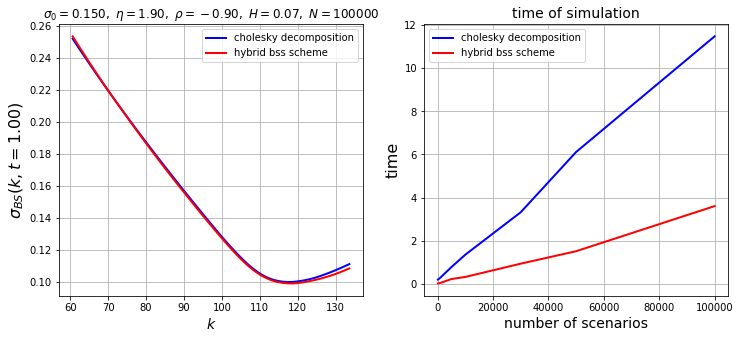

In [28]:
plot, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(K[0],implied_vols2, 'b', lw=2, label="cholesky decomposition")
axes[0].plot(K[0],implied_vols1, 'r', lw=2, label="hybrid bss scheme")
axes[0].set_xlabel(r'$k$', fontsize=14)
axes[0].set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\sigma_0=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ H=%.2f,\ N=%s $'
axes[0].set_title(title%(rb.sigma0, rb.eta, rb.rho, rb.H, 100000), fontsize=12)
axes[0].grid(True)
axes[0].legend()

axes[1].plot(N_list,time_simulation_cholesky, 'b', lw=2, label="cholesky decomposition")
axes[1].plot(N_list,time_simulation_hbss_scheme, 'r', lw=2, label="hybrid bss scheme")
axes[1].set_title("time of simulation", fontsize=14)
axes[1].set_xlabel("number of scenarios", fontsize=14)
axes[1].set_ylabel("time", fontsize=16)
axes[1].grid(True)
axes[1].legend()


## Processes properties verfication :

Now we verify some properties of the processes $Y_t^a$, $V_t$ and $S_t$.

Firstly compute moments of the Volterra process,$$\mathbb{E}[Y_t^a] = 0,\quad \mathbb{V}\left[Y_t^a\right] = t^{2a + 1}$$

In [219]:
paths=0

In [32]:
eY1 = 0 * rB.t # Known expectation
vY1 = rB.t**(2*rB.a + 1) # Known variance
eY2 = np.mean(Y, axis=0, keepdims=True) # Observed expectation
vY2 = np.var(Y, axis=0, keepdims=True) # Observed variance

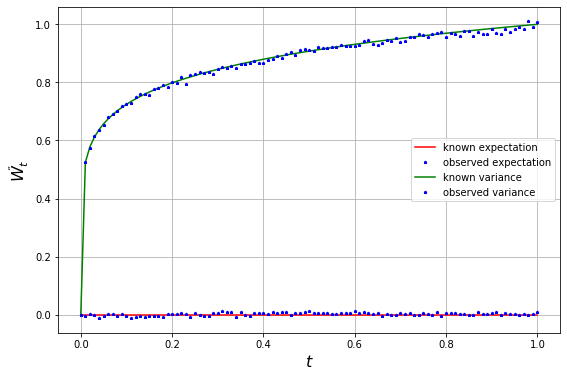

In [45]:
plot, axes = plt.subplots(figsize=(9,6))
axes.plot(rB.t[0,:], eY1[0,:], 'r',label="known expectation")
axes.plot(rB.t[0,:], eY2[0,:], 'b*',label="observed expectation", markersize=3)
axes.plot(rB.t[0,:], vY1[0,:], 'g',label="known variance")
axes.plot(rB.t[0,:], vY2[0,:], 'b*',label="observed variance", markersize=3)
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(Y[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$W^\H_t$', fontsize=16)
plt.legend()
plt.grid(True)

Now check the expectation of the variance process,$$\mathbb{E}[V_t] = \xi$$

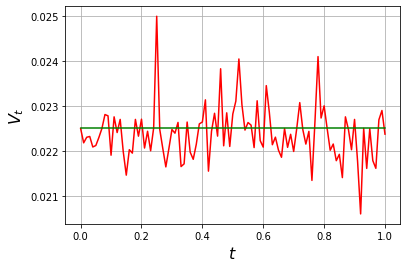

In [47]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], np.mean(V, axis = 0), 'r')
axes.plot(rB.t[0,:], xi * np.ones_like(rB.t)[0,:], 'g')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(V[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$V_t$', fontsize=16)
plt.grid(True)

Finally, we check the log-price process's expectation,$$-2\mathbb{E}[\log{\frac{S_t}{S_0}}] = \int_0^t \mathbb{E}[V_t]\mathrm{d}u = \xi t$$

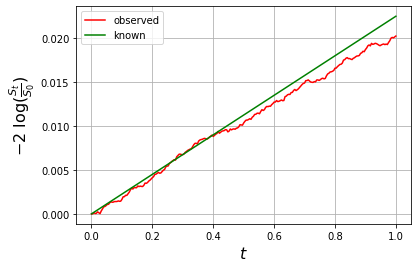

In [234]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], -2*np.mean(np.log(S/S0), axis=0), 'r', label="observed")
axes.plot(rB.t[0,:], xi * rB.t[0,:], 'g', label="known")
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(-2*np.log(S[:paths,:])), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$-2\ \log (\frac{S_t}{S_0})$', fontsize=16)
plt.grid(True)
plt.legend()

## Effect of parameters on volatility smile :

In [141]:
def plot_imp_vols(implied_vols, K, param_list, param_name, ax=None):
    for i in range(len(implied_vols)):
        ax.plot(K[0],implied_vols[i], label=param_name+" = "+str(param_list[i]))
    ax.set_ylabel(r'$\sigma_{BS}(k,T)$', fontsize=16)
    ax.set_title("effect of "+param_name)
    ax.legend()
    ax.grid(True)

In [147]:
def effect_H(S0, K, H=[0.05,0.13,0.2,0.3], T=1.0):
    imp_vols_list=[]
    for h in H:
        S = generate_rBergomi_paths(S0=S0,H=h,T=T,N=100000)
        implied_vols = find_imp_vols(S, K, T=T)
        imp_vols_list.append(implied_vols)
    
    return imp_vols_list

def effect_rho(S0, K, rho=[-0.2,-0.5, -0.9], T=1.0):
    imp_vols_list=[]
    for r in rho:
        S = generate_rBergomi_paths(S0=S0,rho=r,T=T, N=100000)
        implied_vols = find_imp_vols(S, K, T=T)
        imp_vols_list.append(implied_vols)
    
    return imp_vols_list

def effect_eta(S0, K, eta=[0.2,1, 1.9], T=1.0):
    imp_vols_list=[]
    for e in eta:
        S = generate_rBergomi_paths(S0=S0,eta=e,T=T, N=100000)
        implied_vols = find_imp_vols(S, K, T=T)
        imp_vols_list.append(implied_vols)
    
    return imp_vols_list

def effect_sigma0(S0, K, sigma0=[0.05,0.15, 0.3], T=1.0):
    imp_vols_list=[]
    for s0 in sigma0:
        S = generate_rBergomi_paths(S0=S0,sigma0=s0,T=T, N=100000)
        implied_vols = find_imp_vols(S, K, T=T)
        imp_vols_list.append(implied_vols)
    
    return imp_vols_list


Text(0.5, 0, '$k$')

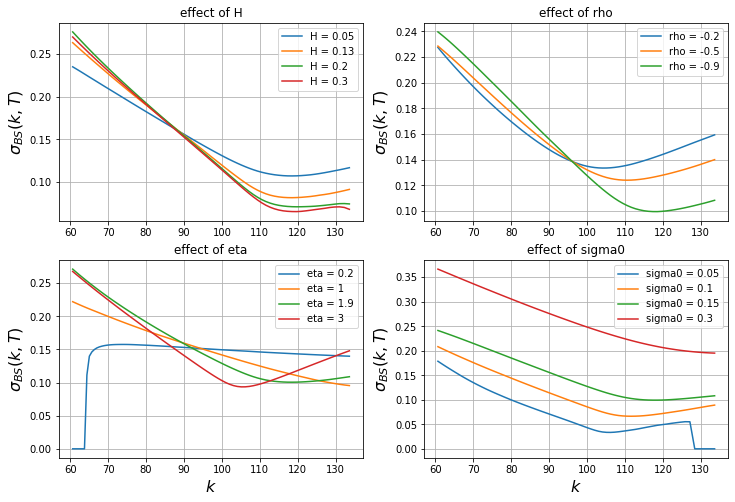

In [145]:
S0 = 100
fig, ax = plt.subplots(2,2 , figsize=(12,8))
H = [0.05,0.13,0.2,0.3]
imp_vols_list = effect_H(S0,K, H)
plot_imp_vols(imp_vols_list, K, H, param_name="H", ax=ax[0,0])

rho=[-0.2,-0.5, -0.9]
imp_vols_list = effect_rho(S0,K, rho)
plot_imp_vols(imp_vols_list, K, rho, param_name="rho",ax=ax[0,1])

eta=[0.2,1, 1.9,3]
imp_vols_list = effect_eta(S0,K, eta, T=1)
plot_imp_vols(imp_vols_list, K, eta, param_name="eta",ax=ax[1,0])

sigma0=[0.05,0.1,0.15, 0.3]
imp_vols_list = effect_sigma0(S0,K, sigma0, T=1)
plot_imp_vols(imp_vols_list, K, sigma0, param_name="sigma0",ax=ax[1,1])
ax[1,0].set_xlabel(r'$k$', fontsize=16)
ax[1,1].set_xlabel(r'$k$', fontsize=16)